In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

import numpy as np
import numpy.linalg as la
import matplotlib


from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import os
from datetime import datetime
import func as func
%matplotlib 

Using matplotlib backend: MacOSX


In [3]:
def write_par():
    '''write parameters in the path named Datapath '''
    f = open(Datapath + "/parameters_run.txt", "w+")
    f.write('intrisic velocity of each active particle: \r\n' + str(c_g) + '\n')

    f.write('time step dt : \r\n' + str(dt) + '\n')
    f.write('Max iteration time : \r\n' + str(tau) + '\n')

    f.write('Number of the active particle :' + '\r\n' + str(N_p) + '\n')
    f.write('Number of the Wall  :' + '\r\n' + str(N_w) + '\n')

    f.write('Diameter of the active particle :' + '\r\n' + str(D) + '\n')
    f.write('Diameter of the wall : \r\n' + str((DW-R)*2) + '\n')
    f.write('noise level : \r\n' + str(eta) + '\n')

    f.write('LJ strength : \r\n' + str(c_LJ) + '\n')
    f.write('MAX cutoff dis for the LJ between particle and wall : \r\n' + str(DW+FWR) + '\n')
    f.write('MIN cutoff dis for the LJ between particle and wall : \r\n' + str(0.8*DW) + '\n')

    f.write('Kspring : \r\n' + str(kspring) + '\n')
    f.write('cutoff dis from equilibrum dis for the spring between particle and particle : \r\n' + str(FR) + '\n')
    
    if c_active ==0:
        f.write('NOT active''\n')
    else:
        f.write('active''\n')
        f.write('alpha(las in the code), continuous changing for theta:\r\n' + str(las)+ '\n')
        if not_adap == False:    
            f.write('parameters discribing the adaptive force(A*(alp * ad_f / (1 + alp * ad_f))), A and alp:\r\n' + str(c_active) +',' + str(alp) + '\n')
    f.close()


In [20]:
def initeration(rp, s_id, rw, n_vec_theta, vec_n, ad_f, actf, N_p, N_w, tot_Fwall=[]):
    # initializefoce by the thermal noise force
    force = eta * (np.random.rand(N_p, 2) - 0.5) / sqdt
    FWfeel = np.zeros((N_w, 2))

    # loop around all movable particles:    
    # calculate repulsive force 
    for p_id in range(0, N_p):
        # print(rp)
        xy = rp[p_id, :]
        # %%%force with wall 
        for i in range(0, N_w):
            vec_n = -rw[i, :] + xy
            dis = la.norm(vec_n)  # calculate distance
            
            if dis - DW < FR:  # only count when within range

                strength = np.min([c_cutoff, c_LJ * (12 * (DW / dis) ** (13))])

                force[p_id, :] += strength * vec_n / dis
                FWfeel[i, :] += strength * vec_n / dis

        
        # %%%force with skin+skin particle
        if p_id in s_id:
            for i in s_id:  # all movable particles

                if i != p_id:  # but can't interact with self

                    vec_n = -rp[i, :] + xy
                    dis = la.norm(vec_n)  # calculate distance
                    if dis - D < FR/2.:

                        # print(dis, x, y, rp[i,0], rp[i,1])
                        strength = np.round(-kskin * (dis - D),
                                            2)  # + np.min([100,c_LJ * (12*(D/dis) ** (13) - 12 * (D/dis) ** (7))])                  
                        # strength = c_r * (1-dis+D)^n_rep;
                        force[p_id, :] = force[p_id, :] + strength * vec_n / dis

        
        # %%%force with other body+skin particle
        for i in range(N_p):  # all movable particles
            
            if i != p_id:  # but can't interact with self
                
                vec_n = -rp[i, :] + xy
                dis = la.norm(vec_n)  # calculate distance
                if dis - D < FR/2.:
                
                    # print(dis, x, y, rp[i,0], rp[i,1])
                    strength = np.round(-kspring * (dis - D),
                                      2)  # + np.min([100,c_LJ * (12*(D/dis) ** (13) - 12 * (D/dis) ** (7))])                  
                    # strength = c_r * (1-dis+D)^n_rep;
                    force[p_id, :] = force[p_id, :] + strength * vec_n / dis

    force[:, 1] += -c_g
    
    pas_force = force.copy()
   
    force[:, 0][s_id] += c_active * (actf * n_vec_theta[:, 0])[s_id]
    force[:, 1][s_id] += c_active * (actf * n_vec_theta[:, 1])[s_id] 
    
    rp = rp + dt * force
    c_rp = np.mean(rp, axis = 0)
    print(c_rp)
    # update active forces if c_active != 0
    if c_active != 0:
        vec_theta[s_id, 0] = c_active * actf[s_id] * n_vec_theta[s_id, 0] * (1 - las) + force[s_id, 0] * las
        vec_theta[s_id, 1] = c_active * actf[s_id] * n_vec_theta[s_id, 1] * (1 - las) + force[s_id, 1] * las
        n_vec_theta[s_id, 0] = vec_theta[s_id, 0] / la.norm(vec_theta, axis=1)[s_id]
        n_vec_theta[s_id, 1] = vec_theta[s_id, 1] / la.norm(vec_theta, axis=1)[s_id]

                      
        if not not_adap:
            ad_f[s_id] = abs(np.sum(force * n_vec_theta, axis=1))[s_id]
            actf = (alp * ad_f / (1 + alp * ad_f))

    return dt * force.copy(), c_rp, rw, n_vec_theta, FWfeel


In [21]:
class DraggablePoint:
    lock = None #only one can be animated at a time
    def __init__(self, point):
        self.point = point
        self.press = None
        self.background = None
        
    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.point.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.point.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.point.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        
    def on_press(self, event):
        if event.inaxes != self.point.axes: return
        if DraggablePoint.lock is not None: return
        contains, attrd = self.point.contains(event)
        if not contains: return
        self.press = (self.point.center), event.xdata, event.ydata
        DraggablePoint.lock = self

        # draw everything but the selected rectangle and store the pixel buffer
        canvas = self.point.figure.canvas
        axes = self.point.axes
        self.point.set_animated(True)
        canvas.draw()
        self.background = canvas.copy_from_bbox(self.point.axes.bbox)

        # now redraw just the rectangle
        axes.draw_artist(self.point)

        # and blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_motion(self, event):
        if DraggablePoint.lock is not self:
            return
        if event.inaxes != self.point.axes: return
        self.point.center, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        self.point.center = (self.point.center[0]+dx, self.point.center[1]+dy)

        canvas = self.point.figure.canvas
        axes = self.point.axes
        # restore the background region
        canvas.restore_region(self.background)

        # redraw just the current rectangle
        axes.draw_artist(self.point)

        # blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_release(self, event):
        'on release we reset the press data'
        if DraggablePoint.lock is not self:
            return

        self.press = None
        DraggablePoint.lock = None

        # turn off the rect animation property and reset the background
        self.point.set_animated(False)
        self.background = None

        # redraw the full figure
        self.point.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.point.figure.canvas.mpl_disconnect(self.cidpress)
        self.point.figure.canvas.mpl_disconnect(self.cidrelease)
        self.point.figure.canvas.mpl_disconnect(self.cidmotion)        

In [5]:
def plot_circles(fig, ax, x, y, r, c='r', cmap=matplotlib.cm.rainbow, ticks=[0, 1]):
    patches = []
    for x1, y1 in zip(x, y):
        circle = plt.Circle((x1, y1), r)
        patches.append(circle)

    if isinstance(c, str):
        p = PatchCollection(patches, facecolor="None", edgecolor=c, alpha=1, linewidths=2)
        ax.add_collection(p)
        return ax

    else:
        p = PatchCollection(patches, cmap=cmap, alpha=0.8)
        p.set_array(np.array(c))

    ax.add_collection(p)

    # cbar = fig.colorbar(p, ax=ax,ticks=ticks)
    p.set_clim(min(ticks), max(ticks))
    return fig,p

def plot_active_force(c_active, alp, c_g):
    plt.plot(np.arange(0,10,0.1),c_active/c_g * (alp * np.arange(0,10,0.1) / (1 + alp * np.arange(0,10,0.1))))
    plt.ylabel('active velocity ($1/c_g$)', fontsize = 20)
    plt.xlabel('total velocity from last time v(t-1)', fontsize = 20)
#     plt.show()

#     plt.savefig(Datapath + '/adaptive_force_profile.png')
    plt.tight_layout()
#     plt.close()


In [6]:
N_s = 0 #skin active connected by spring
tot_Fwall = 0 # total force acting on wall

dt = 0.005

tau = 40
eta = 0.1 #noise 
sqdt = np.sqrt(dt) #noise 

R = 0.5 # radius of beads
D = 2 * R # diameter
RW = 6 * R # radius of Wall
DW = RW + R # distance between center of bead and center of the Wall


FR = R# cutoff range of force between beads(repulsion if surface distance < R)
FWR = 2 * R# cutoff range of force between bead and wall (repulsion if surface distance < 2*R)
c_LJ = 1.

c_cutoff = c_LJ *(12*(DW/(0.8*DW)) ** (13))
print(c_cutoff)
alp = 0.5 #[0,5]

# kspring = 20.

#kappa = 2 
#if =1, angle = the total force direction = actual motion
#if =2. angle = the vector sum of actual motion + active motion


218.27872842550227


1.0


array([[-5.00000000e-01, -1.73200000e+00],
       [ 5.00000000e-01, -1.73200000e+00],
       [-1.00000000e+00, -8.66000000e-01],
       [ 0.00000000e+00, -8.66000000e-01],
       [ 1.00000000e+00, -8.66000000e-01],
       [-5.00000000e-01,  0.00000000e+00],
       [ 5.00000000e-01,  0.00000000e+00],
       [-1.00000000e+00,  8.66000000e-01],
       [ 0.00000000e+00,  8.66000000e-01],
       [ 1.00000000e+00,  8.66000000e-01],
       [-5.00000000e-01,  1.73200000e+00],
       [ 5.00000000e-01,  1.73200000e+00],
       [ 2.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  2.36598140e+00],
       [-1.00000000e+00, -2.36598140e+00],
       [ 2.00000000e+00, -6.69147011e-16]])

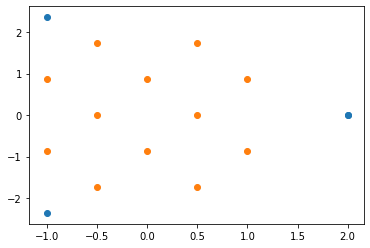

In [7]:
import math
pi = math.pi

def PointsInCircum(a,b,n=100):
    return np.array([[math.cos(2*pi/n*x)*a,math.sin(2*pi/n*x)*b] for x in range(0,n+1)])
# plt.scatter(func.make_hex(3,3)[:,0],func.make_hex(3,3)[:,1]-np.sqrt(1**2-0.5**2))
# plt.scatter(func.make_hex(2,2)[:,0],func.make_hex(2,2)[:,1])
body = func.make_hex(2,2)
body[:,1] = body[:,1]-np.mean(body[:,1])
body = np.round(body,3)
print(np.max(body[:,0]))
xy = PointsInCircum(max(body[:,0])+2*R, max(body[:,1])+2*R,3)
plt.scatter(xy[:,0], xy[:,1])
plt.scatter(body[:,0],body[:,1])
np.concatenate((body,xy), axis = 0)

In [8]:
def initialize():
    
    #initialize positions of everyone
    rb, rs, s_id = make_s_b()
    
    N_b = len(rb)
    plt.scatter(rb[:,0], rb[:,1])
    
    rw = func.make_hex(2,1)
    rw[:,0] = rw[:,0].copy()*(max(rb[:,0])*1.5+2.5*RW)-DW
    rw[:,1] = rw[:,1].copy()*(max(rb[:,1])*1.5+2.5*RW)
    rw[:,1] += -max(rw[:,1].copy())-DW*np.max(rb[:,1])
#     rw = np.array([[-20,0]])
    N_w = len(rw)  
#     thetas_vec = np.array([[0,-1]]) ## initial vector of angle of the activity
    thetas_vec = np.zeros((N_b,2))
    thetas_vec[s_id,1] = np.tile([-1], len(s_id))

    vec_n = np.zeros(2)
    #print(vec_n[1])
    ad_f = np.zeros(N_b)
    ad_f[s_id] = 1
    if not_adap == True:
        actf = ad_f 
    else:
        actf =(alp * ad_f / (1 + alp * ad_f)) #+c_active# active driving force initially 0
       
    return rb, s_id, rw, thetas_vec, vec_n, ad_f, actf, N_b, N_w

def make_s_b():
    body = func.make_hex(2,1)
    body[:,1] = body[:,1]-np.mean(body[:,1])
    body = np.round(body,3)
    print(len(body))
    ra = max(body[:,0])+2*R
    rb = max(body[:,1])+2*R
    big_r = max(ra,rb)
    cir = 2*np.pi*big_r
    print(cir)
    skin = PointsInCircum(ra, rb, n=int(cir))[:int(cir)]#max(int(cir),len(body)))
    plt.scatter(skin[:,0], skin[:,1])
    plt.scatter(body[:,0],body[:,1])
    tot = np.concatenate((body,skin), axis = 0)
    s_id = np.arange(len(body), len(body)+len(skin))

    return tot, skin, s_id


In [9]:
not_adap = False
c_active = 2.
c_g = 2.
las = 0.1 #[0,1] when las=1 the change of theta is instantaneous 
kspring = 5*(c_g+c_active)
kskin = 10*(c_g+c_active)


not instantanous
7
12.566370614359172


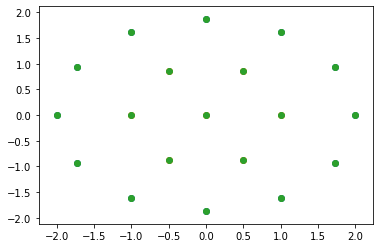

In [10]:
AVEFORCES = []
TIMES = []

if not_adap:
    print('its not adaptive')
if las != 1:
    print('not instantanous')

rp, s_id, rw, n_vec_theta, vec_n, ad_f, actf, N_p, N_w = initialize()
vec_theta = np.zeros(np.shape(n_vec_theta))

tot_Fwall = 0
plt.show()
# rw=[rw[0]]
force = eta * (np.random.rand(N_p, 2) - 0.5) / sqdt
# time = 0
# visualization(not_adap)
# # print(rp[7],rp[19])



In [11]:
c_rp = np.mean(rp, axis = 0)
print(c_rp)

[-1.40238698e-16 -1.75298372e-17]


In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
drs = []

circles = []
for i in range(4):
    x, y = random.uniform(4,6),random.uniform(4,6)
    circles.append(patches.Circle((x, y), 0.5, fc='r', alpha=0.7))

for circ in circles:
    ax.add_patch(circ)
    print(circ)
    dr = DraggablePoint(circ)
    dr.connect()
    drs.append(dr)

fignum = fig.number

while(plt.fignum_exists(fignum)):
    for circ in circles:        
        dx = random.uniform(-.1,.1)
        dy = random.uniform(-.1,.1)#-c_g*0.1
        circ.center = (circ.center[0]+dx, circ.center[1]+dy)
    plt.pause(.2)

Circle(xy=(4.02525, 5.29543), radius=0.5)
Circle(xy=(5.71199, 5.65957), radius=0.5)
Circle(xy=(4.64962, 4.35435), radius=0.5)
Circle(xy=(4.00509, 5.57209), radius=0.5)


In [16]:
%matplotlib 

Using matplotlib backend: MacOSX


In [17]:
def visualization(not_adap):
#     fig = plt.figure(figsize = (8,8))

    ax = fig.add_subplot(111,aspect='equal') 
    plt.title('time at %0.2f'%time+' with active = %0.1f c_g'%(c_active/c_g) ,fontsize=15)
    
    plot_circles(fig,ax,rp[:,0],rp[:,1],R, actf)
    
    fig,p= plot_circles(fig,ax,rw[:,0],rw[:,1],RW,la.norm(FWfeel, axis = 1), cmap = matplotlib.cm.coolwarm, ticks=[0, 100])
    cbar = fig.colorbar(p, ax=ax,orientation="horizontal",fraction=0.07,anchor=(1.0,0.0))
    

    plt.xlabel('force on wall = %d'%tot_Fwall,fontsize=15)
    ax.quiver(rp[:,0],rp[:,1], force[:,0], force[:,1], linewidth = 25, headwidth=10, units = 'xy', scale = 10)
    # ax.quiver(rp[:,0],rp[:,1], c_active*ad_f*n_vec_theta[:,0], 
    #           c_active*ad_f*n_vec_theta[:,1], linewidth = 15, headwidth=10, color= 'b')
    ax.quiver(rw[:,0], rw[:,1], FWfeel[:,0], FWfeel[:,1],
              linewidth = 25, headwidth=10, units = 'xy', scale = 10, color = 'r')

    plt.xlim(np.amin(rw[:,0]-2*RW),np.amax(rw[:,0]+2*RW))
    plt.ylim(np.amin(rw[:,1]-2*RW),np.amax(rw[:,1]+4*RW))
    # plt.xticks([])
    plt.yticks([])

    if not_adap==False and c_active !=0:
        a = plt.axes([0.8, 0.3, .2, .2])
        xx = np.arange(0,20,0.5)
        plt.plot(xx,(alp * xx / (1 + alp * xx)))

        plt.scatter(ad_f, actf, c=actf, cmap = matplotlib.cm.rainbow,
                    vmin=0, vmax=1, alpha = 1.)
        plt.colorbar()
        plt.ylabel('active velocity ',fontsize = 15)
        plt.xlabel('$\|f(t-1)*\hat{n}\|$',fontsize = 15)
        plt.yticks([])

    if len(force[:,0]) ==1:
        a = plt.axes([0.6, 0.6, .2, .2])
        plt.annotate("",xy=(pas_force[:,0], pas_force[:,1]),xytext=(0,0),
                 arrowprops=dict(facecolor='b', shrink=0.05),alpha = 0.5)
 
        plt.annotate("",xy=(c_active*actf*n_vec_theta[:,0], c_active*actf*n_vec_theta[:,1]),xytext=(0,0),
                             arrowprops=dict(facecolor='r', shrink=0.05))
        
        if c_active !=0:
            plt.ylim(-c_g/2.-c_active,c_g/2.+c_active)
            plt.xlim(-c_g/2.-c_active,c_g/2.+c_active)
        else:
            plt.ylim(-2*c_g,2*c_g)
            plt.xlim(-2*c_g,2*c_g)
        plt.xticks([])
        plt.yticks([])
        plt.title('passive(b) vs active(r)',fontsize = 15)

    return fig

    

In [18]:
rp, s_id, rw, n_vec_theta, vec_n, ad_f, actf, N_p, N_w = initialize()

7
12.566370614359172


In [22]:
import sys
fig = plt.figure()


ax = fig.add_subplot(111,aspect='equal') 
ax.set_xlim(np.amin(rw[:,0]-2*RW),np.amax(rw[:,0]+2*RW))
ax.set_ylim(np.amin(rw[:,1]-2*RW),np.amax(rw[:,1]+4*RW))
# plot_circles(fig,ax,rp[:,0],rp[:,1],R, actf)
drs= []
circles = []
for i in range(len(rw)):   
    circles.append(patches.Circle((rw[i,0], rw[i,1]), RW, fc='r', alpha=0.7))

Pcircles = []
for i in range(len(rp)):   
    Pcircles.append(patches.Circle((rp[i,0], rp[i,1]), R, alpha=0.7))

# p = PatchCollection(Pcircles, cmap=matplotlib.cm.rainbow, alpha=0.8)
# p.set_array(np.array(actf))
# ax.add_collection(p)

for circ in circles:
    ax.add_patch(circ)
    print(circ)
    dr = DraggablePoint(circ)
    dr.connect()
    drs.append(dr)
    
for circ in Pcircles:
    ax.add_patch(circ)
    print(circ)
    dr = DraggablePoint(circ)
    dr.connect()
    drs.append(dr)

print(len(rw), len(circles))
time = 0
dt = 0.02
tot_Fwall = []
fignum = fig.number

while(time<10 and plt.fignum_exists(fignum)):
    drp, c_rp, rw, n_vec_theta, FWfeel = initeration(rp, s_id, rw, 
                                                    n_vec_theta, vec_n, ad_f, actf, N_p, N_w)
    tot_Fwall += sum(la.norm(FWfeel, axis=1))
    rp += drp

    i = 0
    for circ in circles:        
        
        circ.center = (circ.center[0], circ.center[1])
        rw[i] = [circ.center[0], circ.center[1]]
        i+=1
    
    i = 0   
    for circ in Pcircles: 
        dx = drp[i,0].copy()
        dy = drp[i,1].copy() #-c_g*0.1
        circ.center = (circ.center[0]+dx, circ.center[1]+dy)       
        i+=1
        
    plt.scatter(c_rp[0], c_rp[1], s=1)
    time += dt
    plt.pause(.01)


Circle(xy=(-8.75, -24.3694), radius=3)
Circle(xy=(1.75, -24.3694), radius=3)
Circle(xy=(-14, -15.4502), radius=3)
Circle(xy=(-2.91821, -13.8503), radius=3)
Circle(xy=(7, -15.4502), radius=3)
Circle(xy=(-8.75, -6.531), radius=3)
Circle(xy=(5.33772, -7.59762), radius=3)
Circle(xy=(-0.834695, -10.1039), radius=0.5)
Circle(xy=(0.177487, -10.2367), radius=0.5)
Circle(xy=(-1.00103, -9.22174), radius=0.5)
Circle(xy=(-0.150178, -9.47455), radius=0.5)
Circle(xy=(0.864702, -9.73479), radius=0.5)
Circle(xy=(-0.568242, -8.46098), radius=0.5)
Circle(xy=(0.467986, -8.67953), radius=0.5)
Circle(xy=(1.29739, -10.6062), radius=0.5)
Circle(xy=(1.18485, -7.07355), radius=0.5)
Circle(xy=(0.674521, -7.50691), radius=0.5)
Circle(xy=(-0.752679, -7.505), radius=0.5)
Circle(xy=(-1.66887, -8.60447), radius=0.5)
Circle(xy=(-3.68424, -9.2314), radius=0.5)
Circle(xy=(-3.35548, -9.8725), radius=0.5)
Circle(xy=(-1.80044, -9.59954), radius=0.5)
Circle(xy=(-0.687956, -10.9646), radius=0.5)
Circle(xy=(0.40213, -11.4437

In [25]:
print(drp)

[[-1.07883067e+37 -1.86767476e+37]
 [ 1.24380225e+37 -1.75995845e+37]
 [-2.15053644e+37 -2.46732940e+35]
 [ 1.06407411e+34 -2.14904852e+35]
 [ 2.15510206e+37 -2.02747794e+35]
 [-1.08016221e+37  1.82900404e+37]
 [ 1.07313150e+37  1.82066349e+37]
 [ 4.25940356e+37 -2.92153344e+35]
 [ 3.64067608e+37  1.94744468e+37]
 [ 2.12723329e+37  3.41935837e+37]
 [-9.05614929e+33  3.91285875e+37]
 [-2.12422650e+37  3.42297882e+37]
 [-3.63916793e+37  1.95057088e+37]
 [-4.25268546e+37 -3.06289295e+35]
 [-3.62541938e+37 -1.98375573e+37]
 [-2.12546883e+37 -3.47692440e+37]
 [-1.56414682e+36 -4.01327774e+37]
 [ 2.42710434e+37 -3.37396041e+37]
 [ 3.64300070e+37 -2.00417003e+37]]


In [70]:
print(circ.center)
rw[0]

(5.337717740488685, -6.434034655662469)


array([ -8.75      , -24.36939127])